**Hand signs recognition using Tensorflow**

In this project, Recognize Hand signs 0-5 using Tensorflow

In [43]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

## Load Dataset

In [3]:
from google.colab import files
uploaded=files.upload()

Saving train_signs.h5 to train_signs.h5
Saving test_signs.h5 to test_signs.h5


both are in h5 files. we have to convert into numpy arrays

In [4]:
#importing required packages to load datasets
import numpy as np
import h5py

In [16]:
train_dataset=h5py.File('train_signs.h5','r')
test_dataset=h5py.File('test_signs.h5','r')

In [17]:
X_train=np.array(train_dataset['train_set_x'][:])
Y_train=np.array(train_dataset['train_set_y'][:])

X_test=np.array(test_dataset['test_set_x'][:])
Y_test=np.array(test_dataset['test_set_y'][:])

classes=np.array(test_dataset['list_classes'][:])

In [18]:
#check the dims
print('shape of X_train :',X_train.shape)
print('shape of Y_train :',Y_train.shape)
print('shape of X_test :',X_test.shape)
print('shape of Y_test :',Y_test.shape)

shape of X_train : (1080, 64, 64, 3)
shape of Y_train : (1080,)
shape of X_test : (120, 64, 64, 3)
shape of Y_test : (120,)


In [19]:
#reshape the labels
Y_train=Y_train.reshape((1,Y_train.shape[0]))
Y_test=Y_test.reshape((1,Y_test.shape[0]))
#now check the dims of labels
print('shape of Y_train :',Y_train.shape)
print('shape of Y_test :',Y_test.shape)


shape of Y_train : (1, 1080)
shape of Y_test : (1, 120)


[2]


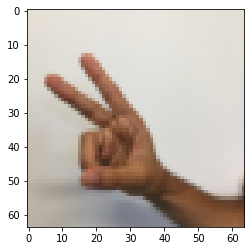

In [20]:
#Let's see some images
import matplotlib.pyplot as plt
plt.imshow(X_train[6])
print(Y_train[:,6])

[1]


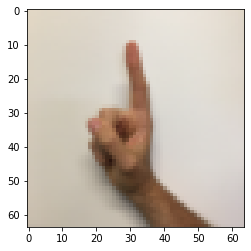

In [21]:
import matplotlib.pyplot as plt
plt.imshow(X_train[611])
print(Y_train[:,611])

Normalizing features

In [22]:
X_train=X_train/255.0
X_test=X_test/255.0

one hot encoding labels

In [23]:
def convert_one_hot(Y,C):
  Y=np.eye(C)[Y.reshape(-1)].T
  return Y

In [24]:
Y_train=convert_one_hot(Y_train,6).T
Y_test=convert_one_hot(Y_test,6).T

In [27]:
#now we have dims
print('shape of X_train :',X_train.shape)
print('shape of Y_train :',Y_train.shape)
print('shape of X_test :',X_test.shape)
print('shape of Y_test :',Y_test.shape)

shape of X_train : (1080, 64, 64, 3)
shape of Y_train : (1080, 6)
shape of X_test : (120, 64, 64, 3)
shape of Y_test : (120, 6)


Now Feature extraction is done

# Model

* create placeholders
* initialize parameters
* forword propagation
* compute cost
* optimization

CONV2D > RELU > MAXPOOL >> CONV2D > RELU > MAXPOOL >> FLATTEN >> FULLYCONNECTED

Create Placeholders

In [36]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype="float", name="X")
    Y = tf.placeholder(shape=[None, n_y], dtype="float", name="Y")
    
    
    return X, Y

Initialize Parameters

In [37]:
def initialize_parameters():

    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

Forward Propagation

In [38]:
def forward_propagation(X, parameters):

    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    # CONV2D: stride of 1, padding 'SAME'
    s = 1
    Z1 = tf.nn.conv2d(X, W1, strides = [1,s,s,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    f = 8
    s = 8
    P1 = tf.nn.max_pool(A1, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    s = 1
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,s,s,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    f = 4
    s = 4
    P2 = tf.nn.max_pool(A2, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
    # FLATTEN
    F = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED 
    num_outputs = 6
    Z3 = tf.contrib.layers.fully_connected(F, num_outputs, activation_fn=None)
    

    return Z3

Compute Cost

In [39]:
def compute_cost(Z3, Y):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    
    return cost

Model- Finalize

In [41]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
   
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    

    # Initialize parameters
    
    parameters = initialize_parameters()

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    
    Z3 = forward_propagation(X, parameters)
    
    
    # Cost function: Add cost function to tensorflow graph
    
    cost = compute_cost(Z3, Y)
    
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss = cost)
    
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

          # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                """
                
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters
        

In [44]:
#_, _, parameters = model(X_train, Y_train, X_test, Y_test)